In [10]:
import json,requests,dateutil
from datetime import datetime,timedelta
import pandas as pd
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
configFile='../Data/CONFIG.json'
inputFile='../Data/input_data.csv'
fileName='../Data/hourlyData.csv'
getConfig=json.loads(open(configFile,'r').read())


In [11]:
df= pd.read_csv(fileName)
df=df[~df['c8y_Flow_F'].isnull()]

<AxesSubplot:>

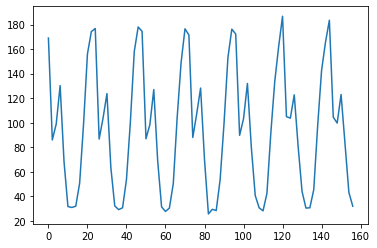

In [12]:
from matplotlib import pyplot
import matplotlib 
#%matplotlib inline 
series = df['c8y_Flow_F']
series.plot()

### Training Model using Nyoka Microservice

In [13]:
tenant_url=getConfig['c_url']
user_name, password = getConfig['c_user'],getConfig['c_pass']
data={}
stDate=df['time'][0]
START_DATE= str(datetime.strptime(stDate, "%Y-%m-%d %H:%M:%S"))
data['startDate']=START_DATE.replace(' ','T')+'+05:30'
seriesData=df['c8y_Flow_F'].values.flatten().tolist()
data['series']=seriesData
interval={}
interval['timeUnit']='HOURS'
interval['periodLength']=2
data['observationInterval']=interval
seasonality={}
seasonality['timeUnit']='HOURS'
seasonality['periodLength']=24
data['seasonality']=seasonality
time_series_data = json.dumps(data)

In [14]:
time_series_data

'{"startDate": "2021-05-25T12:00:00+05:30", "series": [169.0, 86.0, 99.0, 130.25, 68.25, 31.75, 31.0, 32.0, 50.75, 98.75, 156.0, 174.25, 176.75, 86.75, 103.75, 123.75, 63.5, 32.25, 29.25, 30.75, 53.75, 100.5, 158.0, 178.0, 174.5, 87.0, 98.5, 127.0, 69.0, 31.5, 27.75, 30.5, 50.5, 104.5, 149.0, 176.5, 171.5, 88.0, 107.25, 128.25, 70.0, 25.75, 29.5, 28.5, 53.5, 99.25, 153.0, 176.25, 172.25, 89.75, 103.25, 132.0, 80.0, 40.75, 30.75, 28.25, 42.5, 91.75, 133.5, 162.0, 186.75, 105.0, 103.75, 122.75, 80.5, 44.0, 30.5, 30.75, 45.5, 97.5, 142.5, 165.5, 183.5, 104.5, 99.75, 123.0, 83.25, 43.25, 32.0], "observationInterval": {"timeUnit": "HOURS", "periodLength": 2}, "seasonality": {"timeUnit": "HOURS", "periodLength": 24}}'

In [15]:
postURL=tenant_url+"service/zementis/train/timeseries"
post_resp=requests.post(url=postURL,data=time_series_data,headers = {'content-type': 'application/json'},auth=(user_name, password),verify=True)

In [16]:
post_resp.text

'{\n  "modelName" : "Timeseries_07-06-2021_02-43-17_mOjvA",\n  "statusUrl" : "/service/zementis/train/timeseries/Timeseries_07-06-2021_02-43-17_mOjvA/status"\n}'

In [17]:
uploaded_model=json.loads(post_resp.text)['modelName']
model_uploaded_status_url=json.loads(post_resp.text)['statusUrl']
model_uploaded_status_url

'/service/zementis/train/timeseries/Timeseries_07-06-2021_02-43-17_mOjvA/status'

In [18]:
tenant_url[:-1]+model_uploaded_status_url

'https://mlw.basic.stage.c8y.io/service/zementis/train/timeseries/Timeseries_07-06-2021_02-43-17_mOjvA/status'

In [21]:
status=True
while status:
    status_resp =requests.get(url=tenant_url[:-1]+model_uploaded_status_url,auth=(user_name, password),verify=True)
    status_resp
    respStatus=json.loads(status_resp.text)['status']
    if respStatus=='SUCCESS':
        status=False
    else:
        import time
        time.sleep(10)
        print ('Training in Progress')
print ('Training Completed')


Training Completed


## Score

In [22]:
url = tenant_url+'service/zementis/apply/'+uploaded_model
prediction_response=requests.get(url = url, params = 'record={"h":12}', auth=(user_name, password), verify=True) 


In [23]:
predictedValues=pd.DataFrame([json.loads(prediction_response.text)['outputs'][0]['predicted_value_0']]).transpose()

In [24]:
predictedValues=predictedValues.reset_index()
predictedValues.columns=['hours','c8y_Flow_F']
predictedValues['hours']=predictedValues['hours'].apply(int).apply(lambda x: x*2)
predictedValues=predictedValues.sort_values(by=['hours'],ascending=True)
predictedValues=predictedValues.reset_index()
del predictedValues['index']
predictedValues

hours  c8y_Flow_F
0       2   31.478780
1       4   46.082952
2       6   96.688398
3       8  140.759107
4      10  164.227177
5      12  182.233328
6      14  103.880415
7      16  100.311214
8      18  122.736992
9      20   82.788630
10     22   43.891348
11     24   32.591892

In [25]:
# !pip install matplotlib

### Predicted Hourly Consumption


 The Peak Consumption observed at 5 hours and its predicted value :: 182.2333275034317

 The Minimum Consumption observed at 0 hours and its predicted value :: 31.478779704369078


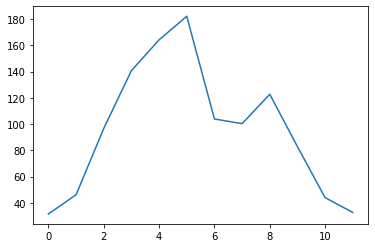

In [26]:
from matplotlib import pyplot
import matplotlib 
#%matplotlib inline 
series = predictedValues['c8y_Flow_F']
series.plot()

peak_hour_index=predictedValues['c8y_Flow_F'].to_list().index(max(predictedValues['c8y_Flow_F']))
min_hour_index=predictedValues['c8y_Flow_F'].to_list().index(min(predictedValues['c8y_Flow_F']))
print('\n The Peak Consumption observed at '+str(peak_hour_index)+' hours and its predicted value :: '+str(max(predictedValues['c8y_Flow_F'])) )
print('\n The Minimum Consumption observed at '+str(min_hour_index)+' hours and its predicted value :: '+str(min(predictedValues['c8y_Flow_F'])) )
